# 0. Install instructions

The following are directions to install the package locally or on google CoLab. I have done all development and testing on the Caltech HPC Cluster using both CPU and GPU nodes requested through OpenOnDemand, so if you have an account on the cluster, you could do the same.

### Installing locally:

You may wish to test the CPU functionality on your local machine. Be sure that an up-to-date version of Python3 is installed in order to build and run this package. Download the source code from: https://github.com/edejong-caltech/PySDM/tree/edj-Breakup, or install using suggested steps below.

In [ ]:
!git clone -b edj-Breakup https://github.com/edejong-caltech/PySDM.git
!cd PySDM

Build the module. Be sure all requirements are install and up to date.

In [ ]:
!pip3 install -r requirements.txt
!pip3 install -e .

Tests and examples that use breakup can be found in "../PySDM_tests", including this notebook.

You can view all the contributions that I have made to this code base by comparing it to the original: https://github.com/atmos-cloud-sim-uj/PySDM

### Installing and running on Google CoLab
To run the code in this notebook with GPU acceleration, I recommend downloading the notebook and running it in Google CoLab. Navigate to: https://research.google.com/colaboratory/ and follow the next steps to download the code.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install git+https://github.com/edejong-caltech/PySDM@edj-Breakup
    !ldconfig

You may get an error the first time about the version of notebook and tornado--that's okay. **Restart the runtime (Runtime -> restart Runtime) and re-run this cell** as a workaround, and there should be no issues.

## Import statements:

In [32]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Breakup
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae

from numba import config, threading_layer
config.THREADING_LAYER = 'threadsafe'

If importing above leads to any errors, be sure you have installed the code correctly.

# 1. Background and functionality

PySDM is an existing superdroplet-method code that can handle many sets of particle processes, excluding breakup, based on the superdroplet method described in Shima et al 2009. The purpose of this project is to add a breakup-type process to the codebase for future research and testing. I extend the current implementation of particle coalescence to include breakup as well, with the following algorithm (new pieces bolded). My contributions and modifications can be found in the following source code files:

- backends/numba/impl/_algorithmic_methods.py
- backends/thrustRTC/impl/_algorithmic_methods.py
- dynamics/impl/random_generator_optimizer_nopair.py
- dynamics/breakup.py
- dynamics/coalescence.py
- physics/breakup_fragmentation/*
- physics/coalescence_efficiencies/*
- state/particles.py

### Algorithm:
1. Randomly order the existing list of superdroplets, and generate a random number for collision probability. **Also generate a random number for fragmentation.**

2. Group the ordered list of superdroplets into pairs.

3. a) Compute the probability of a collision, based on collision kernel
      - **Coalescence and breakup take an additional argument: coalescence efficiency $E_c$.** This required a minor modification to the backend for "PySDM/dynamics/coalescence.py" and a new module "PySDM/physics/coalescence_efficiences.py".
      - **As in the literature, coalescence proceeds with rate $K(x,y)E_c$ and breakup with rate $K(x,y)(1-E_c)$ where $K(x,y)$ is the rate of collisions between particles of size $x$ and $y$.**

   b) **Compute the number of fragments resulting from collisional breakup. This could be either:**
      - **Deterministic, as in 'AlwaysN.py'**
      - **Random, as in 'SLAMS.py' which calls an additional backend kernel in '_algorithmic_methods.py'**
   
4. Compute $\gamma$, the number of collisions that lead to **breakup** (rather than to coalescence).

5. Perform the **breakup step.**
   

#### **Breakup step**

The breakup step that updates particle attributes, which is called from "dynamics/breakup.py" and "state/particles.py", is based on the backend kernel for coalescence with modifications to include the fragmentation. The CPU backend source code is found in **"backends/numba/impl/_algorithmic_methods.py"** and the GPU backend source is in **"backends/ThrustRTC/impl/_algorithmic_methods.py"**. The steps are as follows:

- If $\gamma = 0$, no collision; continue
- Else, for particles $j, k$ with multiplicities $n[j]$ and $n[k]$ and extrinsic attributes $a[j]$ and $a[k]$, find the new number of particles $n'[j] = n[j] - \gamma n[k]$

- If $n'[j] > 0$, update the attributes and particle counts:
    * $n[j]$ = $n'[j]$, $a[j]$ unchanged
    * $n[k]$ = $n[k] * n_{fragment}$
    * $a[k]$ = $\frac{a[k] + \gamma a[j]}{n_{fragment}}$
- Else split the resulting single droplet $a[k]$ into two superdroplets with equal attributes and half the multiplicity.

- If any SD multiplicities are zero, flag them.

# 2. Demonstration of functionality:

Here is a demonstration of some of the physics options that you can use in simple "box setting": particles are allowed to collide and coalesce or breakup, and you'll see how the particle size distribution changes after a few time steps of the dynamics. 

Specify whether you prefer to use a GPU or CPU backend in the run cell; if you want to use a GPU in Google CoLab, you will need to request one by selecting **Runtime -> Change runtime type ->** select **GPU** from the **Hardware Accelerator** dropdown, and you will need to re-run the first cells to import, restart, and re-import (the tornado workaround) the module.

### a. Simple breakup only
The following demonstrates an initial droplet population in a zero-D "Box" that undergoes only breakup.

In [33]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 60, 120]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)     # no collisions
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

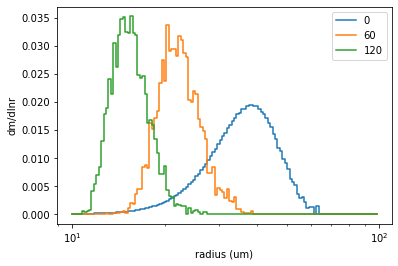

In [37]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

Notice that as time progresses, the droplet mass spectrum shifts toward smaller and smaller droplets due to fragmentation.

### b. Stochastic Fragmentation
This time we will use the stochastic SLAMS fragmentation function rather than the simple constant fragmentation number above.

In [38]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 30, 60]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)     # no collisions
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

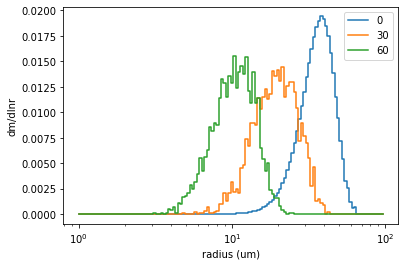

In [39]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')#, label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

In this example, we simulate only 1 minute rather than 2 minutes. Notice first that the breakup happens much more quickly, since particles are able to fragment into more pieces. Notice also the more jagged profile following breakup: because the number of fragments is determined stochastically as well as the collision probability, there is more noise in the product size distribution.

In reality, this SLAMS kernel is taken from a paper on phytoplankton and microphysics droplets have a tendency to fragment most often into two fragments.

### c. Collisions and Breakup: constant collection efficiency
In this example, we allow both collisions and breakup, mitigating the ratio of the two with the collision efficiency Ec. For now let's stick with the same Golovin kernel from above. Try playing with the setting of ConstEc in settings to change the relative amount of breakup/collisions.

In [40]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 60, 120]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.4)
        self.fragmentation = AlwaysN(n=2)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

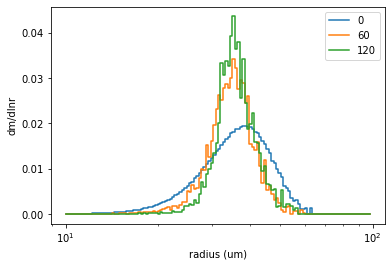

In [42]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')#, label="t = {step*settings.dt}s")
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

This case is a little more nuanced: since collisions and breakup both proceed, it appears that the main mode of the distribution does not change, but the distribution narrows due to the uniform fragmentation. This is a fun scientific question that has arisen for me out of this project: perhaps it would make more sense to allow noninteger numbers of fragments. 

If you decrease Ec or increase the number of fragments to $n=3$, breakup will eventually take over.

### d. Collisions and Breakup with realistic kernel & efficiency

For this final example, let us shift to the most physically realistic "hydrodynamic" collision kernel with a collection efficiency parameterized by E.X. Berry in his 1967 paper.

In [43]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 10, 20]
        self.kernel = Geometric()
        self.coal_eff = Berry1967()
        self.fragmentation = AlwaysN(n=2)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

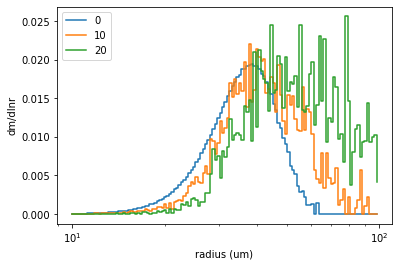

In [44]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

And, as a final comparison, here is the same set of dynamics, including the collection efficiency, with no breakup. It is controversial in the literature whether breakup is significant enough to include as a process for this type of simulation, but clearly in this instance in makes a difference in the dynamics.

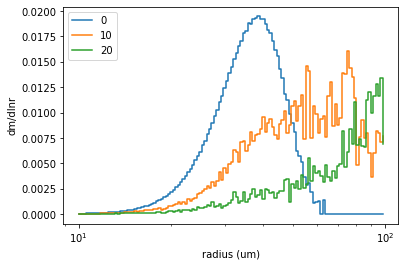

In [45]:
settings = Settings()

backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
#builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post')
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend(settings._steps)

# 3. GPU versus CPU performance

One of the allures of the superdroplet method for simulating cloud droplets for climate is the fact that the algorithm is well-suited to GPU acceleration. You'll notice that for both the CPU and GPU backends, the kernels are written such that the attributes of a pair of superdroplets can be updated within a single thread, and independent of any other superdroplets in the system. The GPU backend ThrustRTC takes care of some of the lower level CUDA calls, and in the backend code we simply ask it to perform the fragmentation or breakup operations by launching a thread for each of the $n/2$ superdroplet pairs.

Below you'll see some code I use to compare the efficiencies of the two options--**you may want to avoid running these cells on your laptop or CoLab (these results come from the Caltech HPC cluster)** and I would not recommend running the CPU version with more than $2^{16}$ superdroplets on your own computer. Scroll down to see the final results and analysis. We'll use stochastic breakup with a Golovin collision kernel, run for 50 time steps and varying numbers of superdroplets. While a GPU cannot accelerate the simulation in terms of time steps, we expect it to show an advantage in scaling with the number of droplets.

In [4]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Breakup
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae

from numba import config, threading_layer
config.THREADING_LAYER = 'threadsafe'

In [15]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [50]
        self.kernel = Golovin(b=1500 / si.s)
        self.coal_eff = ConstEc(0.5)
        self.fragmentation = AlwaysN(n=2)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

## CPU performance:

In [25]:
settings = Settings()
backend = CPU
n_sd = [2**8, 2**10, 2**12, 2**14, 2**16, 2**18, 2**20, 2**22]
cpu_timer = np.zeros(8)

for i in range(8):
    builder = Builder(n_sd=n_sd[i], backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(n_sd[i])
    breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
    builder.add_dynamic(coalescence)
    products = [ParticlesVolumeSpectrum(), WallTime()]
    core = builder.build(attributes, products)

    for step in settings.output_steps:
        core.run(step - core.n_steps)
        cpu_timer[i] = core.products['wall_time'].get()
        print(i, n_sd[i], cpu_timer[i])
    

0 256 0.24165296903811395
1 1024 0.23106306907720864
2 4096 0.26864898204803467
3 16384 0.4547691160114482
4 65536 1.2663282849825919
5 262144 5.036488363984972
6 1048576 25.2533513950184
7 4194304 108.01851987198461


## GPU performance:

In [28]:
settings = Settings()
backend = GPU
n_sd = [2**8, 2**10, 2**12, 2**14, 2**16, 2**18, 2**20, 2**22]
gpu_timer = np.zeros(8)

for i in range(8):
    builder = Builder(n_sd=n_sd[i], backend=backend, formulae=settings.formulae)
    builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
    attributes = {}
    attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(n_sd[i])
    breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
    builder.add_dynamic(breakup)
    coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
    builder.add_dynamic(coalescence)
    products = [ParticlesVolumeSpectrum(), WallTime()]
    core = builder.build(attributes, products)

    for step in settings.output_steps:
        core.run(step - core.n_steps)
        gpu_timer[i] = core.products['wall_time'].get()
        print(i, n_sd[i], gpu_timer[i])
    

0 256 0.564072372042574
1 1024 0.7466771219624206
2 4096 0.7668845719890669
3 16384 0.7765082769328728
4 65536 0.8673726209672168
5 262144 1.0769956399453804
6 1048576 9.39370586303994
7 4194304 43.357991010998376


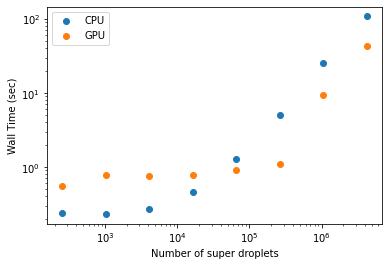

In [27]:
pyplot.scatter(x=n_sd, y=cpu_timer,label='CPU')
pyplot.scatter(x=n_sd, y=gpu_timer, label='GPU')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('Number of super droplets')
pyplot.ylabel('Wall Time (sec)')
pyplot.legend()

Whether you ran the code yourself or simply are following along, hopefully you will notice that the GPU took significantly less time to run the same set of simulations when we used more than around $2^{16}$ superdroplets thanks to threading. However, for fewer superdroplets, the GPU acceleration is not apparent, as latency and memory allocations led the GPU version to take nearly the same amount of wall time for $2^8$ as for $2^{16}$ droplets. For most superdroplet simulations, we desire to live in the realm of about $2^{16} - 2^{18}$ superdroplets per simulation grid box, making the factor of 2-5x speedup from using a GPU for each grid box very desirable, particularly when more dynamics than just coalescence and breakup are involved.

On the other hand, I will note that this amount of GPU acceleration is far below what we might hope for from better-suited GPU accelerated codes. The GPU backend "ThrustRTC" could be responsible for some of this, as could warp divergence caused by the stochastic breakup kernel (you will note that the SLAMS_fragmentation kernel might execute a different number of loops given a different random number). That said, given that this entire code base is still in its infancy, the fact that it can support both CPU and GPU parallelization and now also support the breakup process is a great triumph for atmospheric microphysics!